In [2]:
%load_ext autoreload
%autoreload 2
import os
import sys
from pathlib import Path
import networkx as nx
import pandas as pd
sys.path.insert(0, Path.cwd().absolute())

BASE_DIR = (Path.cwd()).parent

In [4]:
from flow_assignment.flow_assignment import FlowAssignment
from geoprocessing.faf_zone_network import FafZoneNetwork
import geopandas as gpd

In [5]:
naRailNodesDf = gpd.read_file( BASE_DIR / "inputs/NTAD_North_American_Rail_Network_Nodes")
naRailLinesDf = gpd.read_file( BASE_DIR / "inputs/NTAD_North_American_Rail_Network_Lines")
fafZonesDf = gpd.read_file( BASE_DIR / "inputs/2017_CFS_Metro_Areas_with_FAF").to_crs(4326)


In [6]:
fzn = FafZoneNetwork(naRailNodesDf, naRailLinesDf, fafZonesDf).setInputDfColType()
railnet = fzn.createNetwork(write_to=BASE_DIR / "resources/networks/faf_railnet.gml")

/home/nathanczh/ctsm/faf_flow_assignment/src/geoprocessing/faf_zone_network.py:45: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fafZoneNodesDf.geometry = fafZoneNodesDf.centroid


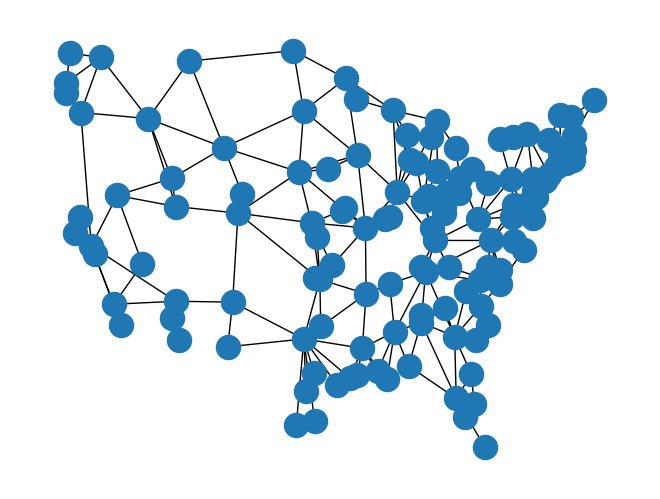

In [7]:
nx.draw(railnet, {
  n: (d['x'], d['y'])
  for n, d in railnet.nodes(data=True)
})

In [8]:
fa = FlowAssignment(SUM_COLUMN='thousand tons in 2050')
railnet_flows = fa.run(railnet, pd.read_csv(Path.cwd().parent / 'inputs/faf_freight_flow.csv' ))
output = fzn.apply_flows_from_network(railnet_flows)

<Axes: title={'center': 'Histogram of freight flows'}, xlabel='Millions of Tons per year', ylabel='Frequency'>

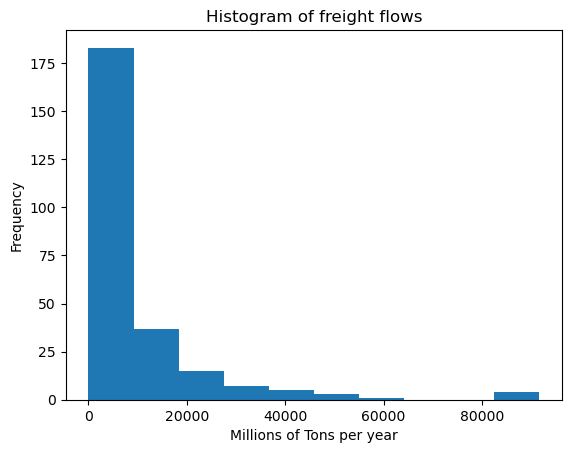

In [47]:
output['weight'].plot(
  kind='hist',
  title='Histogram of freight flows',
  xlabel='Millions of Tons per year'
)

In [42]:
import folium
import branca.colormap as cm

min_lat=24.7433195
max_lat=49.3457868
min_lon=-124.7844079
max_lon=-66.9513812


m = folium.Map(
  max_bounds=True,
  location=[42, -95],
  zoom_start=4,
  min_zoom=4,
  tiles='OpenStreetMap',
  max_lat=max_lat,
  min_lon=min_lon,
  max_lon=max_lon,
  min_lat=min_lat
)

# m.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])

wmax = output['weight'].max()
wmin = output['weight'].min()
def norm_w(feature):
  return (feature['properties']['weight'] - wmin)/(wmax-wmin)

lineWeightMax = 4
lineWeightMin = 0.75

output.explore(
  m=m,
  column='weight',
  style_kwds={
    'style_function': lambda feature: {
      'color': cm.linear.plasma(norm_w(feature)),
      'weight': norm_w(feature) * (lineWeightMax - lineWeightMin) + lineWeightMin
    }
  }
)

fzn.fafZoneNodesDf.explore(
  m=m,
  color='black'
)

folium.LayerControl().add_to(m)
m

In [52]:
output.sort_values('weight', axis=0, ascending=False).reset_index()[['FAF_Zone_1_fr', 'FAF_Zone_1_to', 'weight']]

,FAF_Zone_1_fr,FAF_Zone_1_to,weight
0,Arkansas,Remainder of Missouri,91691.0
1,Remainder of Minnesota,North Dakota,88976.0
2,Remainder of Illinois,Iowa,85487.0
3,Iowa,Remainder of Minnesota,82758.0
4,Remainder of Kentucky,Remainder of Tennessee,62874.0
...,...,...,...
250,"New York-Newark, NY-NJ-CT-PA CFS Area (NY Part)","New York-Newark, NY-NJ-CT-PA CFS Area (PA Part)",0.0
251,"Oklahoma City-Shawnee, OK CFS Area","Tulsa-Muskogee-Bartlesville, OK CFS Area",0.0
252,"Columbus-Marion-Zanesville, OH CFS Area","Dayton-Springfield-Sidney, OH CFS Area",0.0
253,"Cincinnati-Wilmington-Maysville, OH-KY-IN CFS...","Dayton-Springfield-Sidney, OH CFS Area",0.0
